In [1]:
# IMPORTS FOR ALL THE PROJECT
import numpy as np
import os
import requests
from numpy.random import default_rng
import matplotlib
import matplotlib.pyplot as plt
import tarfile
from six.moves import urllib
import pandas as pd



In [2]:
# PATH TO THE FILES

urls= ['https://raw.githubusercontent.com/Plexiglace-EL/projet-IA/main/X_data.csv',
       'https://raw.githubusercontent.com/Plexiglace-EL/projet-IA/main/manager_survey_data.csv',
       'https://raw.githubusercontent.com/Plexiglace-EL/projet-IA/main/employee_survey_data.csv',
       'https://raw.githubusercontent.com/Plexiglace-EL/projet-IA/main/in_time.csv',
       'https://raw.githubusercontent.com/Plexiglace-EL/projet-IA/main/out_time.csv']

paths = ['./datasets/general_data.csv',
         './datasets/manager_survey_data.csv',
         './datasets/employee_survey_data.csv',
         './datasets/in_time.csv',
         './datasets/out_time.csv']

In [3]:

def fetch_datas(url, path):
    localfile, header = urllib.request.urlretrieve(url, path)
    print(localfile)
    return localfile

def extractZip(path):
    with tarfile.open(path) as tf:
        tf.extractall('./datasets')


In [4]:
def import_all_files():
    print('==='*4, "BEGIN", '==='*4)


    if not os.path.exists('./datasets/'):
        print('==='*4, "CREATING \"./datasets/\" DIRECTORY", '==='*4)
        os.mkdir('./datasets')

    for i, url in enumerate(urls):
        fetch_datas(urls[i], paths[i])

    print('==='*4, "FINISHED", '==='*4)

In [5]:
def load_datas(path):
    datas = pd.read_csv(path)
    return datas

In [6]:
#import_all_files()

In [7]:
general = load_datas(paths[0])
manager_survey = load_datas(paths[1])
employee_survey = load_datas(paths[2])
in_time = load_datas(paths[3])
out_time = load_datas(paths[4])

In [8]:
def converting_string_to_dates(in_time, out_time):
    # RENAMING THE UNNAMED COLUMN (ID_EMPLOYEE) FOR IT TO BE USEABLE MORE EASILY IN THE FUTURE

    in_time = in_time.rename(columns={'Unnamed: 0': 'id_employee'})
    out_time = out_time.rename(columns={'Unnamed: 0': 'id_employee'})


    # WE CAN USE THE COLUMNS OF ONLY ONE FILE BECAUSE THEY ARE BOTH THE SAME AND CONTAINS THE SAME HEADERS NAME
    # IT HAS BEEN VERIFIED USING LIST COMPARISON AND UNIQUE() CONDITION TO FILTER AND WE END WITH A TOTAL OF 262 COLUMNS
    cols = in_time.columns


    # CONVERTING THE DATES TO REAL PANDAS DATES OBJECT
    for i in cols:
        if i != 'id_employee':
            in_time[i] = pd.to_datetime(in_time[i])
            out_time[i] = pd.to_datetime(out_time[i])

    return in_time, out_time

In [9]:
#converting in and out time dataframes into pandas date obj
in_time, out_time = converting_string_to_dates(in_time, out_time)

In [10]:
# using the converted dates to calculate the working time of each employee
def calculate_working_time():

    working_time = in_time.copy()
    for i in working_time:
        if i != 'id_employee':
            working_time[i] = out_time[i] - working_time[i]
            
    return working_time

In [11]:
working_time = calculate_working_time()

In [12]:
# Adding the calculated mean value of the working time of each employee to the main dataframe
mean_time = working_time.copy()
mean_time = mean_time.drop('id_employee', axis=1)
general['mean-timework'] = mean_time.mean(axis = 1)
general['mean-timework'] = general['mean-timework'].dt.total_seconds() / 3600
general['mean-timework'] = round(general['mean-timework'], 2)
# Adding the rest of the datas (from the survey)
general['EnvironmentSatisfaction'] = employee_survey['EnvironmentSatisfaction']
general['JobSatisfaction'] = employee_survey['JobSatisfaction']
general['WorkLifeBalance'] = employee_survey['WorkLifeBalance']
general['JobInvolvement'] = manager_survey['JobInvolvement']
general['PerformanceRating'] = manager_survey['PerformanceRating']

# Reformating the column of the existing general DF for comprehension
general = general.reindex(columns=['EmployeeID','Age','Attrition','BusinessTravel','Department','DistanceFromHome','Education','EducationField','EmployeeCount','Gender','JobLevel','JobRole','MaritalStatus','MonthlyIncome','NumCompaniesWorked','Over18','PercentSalaryHike','StandardHours','StockOptionLevel','TotalWorkingYears','TrainingTimesLastYear','YearsAtCompany','YearsSinceLastPromotion','YearsWithCurrManager','mean-timework','EnvironmentSatisfaction','JobSatisfaction','WorkLifeBalance','JobInvolvement','PerformanceRating'])


In [13]:
general.columns

Index(['EmployeeID', 'Age', 'Attrition', 'BusinessTravel', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'Gender', 'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'mean-timework', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating'],
      dtype='object')

In [14]:
general["NumCompaniesWorked"] = general["NumCompaniesWorked"].fillna(general["NumCompaniesWorked"].median())
general["TotalWorkingYears"] = general["TotalWorkingYears"].fillna(general["TotalWorkingYears"].median())

environmentSatisMean = general["EnvironmentSatisfaction"].mean(axis = 0)
jobSatisMean = general["JobSatisfaction"].mean(axis=0)
worklifemean = general["WorkLifeBalance"].mean(axis=0)

for a, value in general['EnvironmentSatisfaction'].isnull().iteritems():
    if value:
        general['EnvironmentSatisfaction'][a] = environmentSatisMean

for a, value in general["JobSatisfaction"].isnull().iteritems():
    if value:
        general['JobSatisfaction'][a] = jobSatisMean

for a, value in general["WorkLifeBalance"].isnull().iteritems():
    if value:
        general['WorkLifeBalance'][a] = worklifemean
        
general.isna().sum()

<ipython-input-14-695455f30af3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general['EnvironmentSatisfaction'][a] = environmentSatisMean
<ipython-input-14-695455f30af3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general['JobSatisfaction'][a] = jobSatisMean
<ipython-input-14-695455f30af3>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general['WorkLifeBalance'][a] = worklifemean


EmployeeID                 0
Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
EmployeeCount              0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
Over18                     0
PercentSalaryHike          0
StandardHours              0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
mean-timework              0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
JobInvolvement             0
PerformanceRating          0
dtype: int64

In [15]:

# for i in general.columns:
#        general[i] = general[i].fillna(0)
X = general.loc[:, :]


# ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18']
y = general.Attrition
X = X.drop(columns=['EmployeeID', 'EmployeeCount', 'Attrition'], axis=1)


In [16]:
X.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,mean-timework,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,Married,...,6,1,0,0,7.37,3.0,4.0,2.0,3,3
1,31,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,Single,...,3,5,1,4,7.72,3.0,2.0,4.0,2,4
2,32,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,Married,...,2,5,0,3,7.01,2.0,2.0,1.0,3,3
3,38,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,Married,...,5,8,7,5,7.19,4.0,4.0,3.0,2,3
4,32,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,Single,...,2,6,0,4,8.01,4.0,1.0,3.0,3,3


In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
logreg = LogisticRegression(solver='lbfgs')

In [19]:
from sklearn.model_selection import cross_val_score

cross_val_score(logreg, X, y, cv=5, scoring='accuracy').mean()

C:\Users\valou\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\valou\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\valou\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1344, in fit
    X, y = self._validate_data(X, y, accept_sparse='csr', dtype=_dtype,
  File "C:\Users\valou\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\valou\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\valou\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 814, in check_X_y
    X = check_array(X, acc

nan

In [20]:
num_attribs = list(X.select_dtypes(include=[np.number]))
cat_attribs = list(X.select_dtypes(exclude=[np.number]))

In [21]:
# Encoder to convert the text data to actual values, it returns a corresponding matrix and the converted column

from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()

    
def personnal_encoder(df, col):

    df[col] = label_enc.fit_transform(df[col])
    return df

def label_encoding(X):
    for i in cat_attribs:
        X = personnal_encoder(X, i)

In [22]:
from sklearn.preprocessing import StandardScaler
def standard_scaler(X):
    sts = StandardScaler()
    X_num = X.loc[:, num_attribs]
    sts.fit(X_num )
    X_num = pd.DataFrame(sts.transform(X_num), columns=num_attribs)
    for i in X_num.columns:
        X[i] = X_num[i]
    

    

In [23]:
# sts = StandardScaler()
# print(num_attribs)
# print(X.columns)
# tmp = X.loc[:, ['DistanceFromHome']]
# sts.fit(tmp)
# tmp = pd.DataFrame(sts.transform(tmp), columns=['DistanceFromHome'])
# tmp.describe()

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

prep_pipeline = Pipeline(
    [
        ('prep', FunctionTransformer(label_encoding(X))),
        ('scaler', FunctionTransformer(standard_scaler(X)))

    ]
)

prep_pipeline.fit(X, y)
X.head(10)


,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,mean-timework,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,1.541369,2,2,-0.393938,-0.891688,1,0,-0.961486,0,1,...,2.483396,-0.981014,-0.679146,-1.155935,-0.246865,0.253684,1.157584,-1.082946,0.379672,-0.426230
1,-0.648668,1,1,0.099639,-1.868426,1,0,-0.961486,6,2,...,0.155707,-0.327893,-0.368715,-0.034520,0.014305,0.253684,-0.662869,1.761536,-1.026167,2.346151
2,-0.539166,1,1,0.963398,1.061787,4,1,1.749610,7,1,...,-0.620189,-0.327893,-0.679146,-0.314873,-0.515497,-0.664142,-0.662869,-2.505188,0.379672,-0.426230
3,0.117845,0,1,-0.887515,2.038524,1,1,0.845911,1,1,...,1.707500,0.161947,1.493867,0.245834,-0.381181,1.171511,1.157584,0.339295,-1.026167,-0.426230
4,-0.539166,2,1,0.099639,-1.868426,3,1,-0.961486,7,2,...,-0.620189,-0.164613,-0.679146,-0.034520,0.230702,1.171511,-1.573095,0.339295,0.379672,-0.426230
5,0.993860,2,1,-0.147150,0.085049,1,0,1.749610,5,1,...,1.707500,-0.001333,1.493867,0.806541,2.312598,0.253684,-0.662869,-1.082946,0.379672,-0.426230
6,-0.977174,2,1,0.223033,-0.891688,3,1,-0.057788,7,2,...,-0.620189,-1.144294,-0.679146,-1.155935,-0.582655,-1.581969,0.247358,-2.505188,0.379672,2.346151
7,-0.867672,2,1,1.086793,0.085049,1,1,-0.057788,7,1,...,-0.620189,-1.144294,-0.679146,-1.155935,-0.724432,-1.581969,-0.662869,0.339295,0.379672,2.346151
8,-0.648668,2,1,-1.010909,0.085049,1,1,0.845911,2,1,...,-0.620189,0.325228,1.493867,1.086895,-0.343871,-0.664142,1.157584,0.339295,0.379672,2.346151
9,-1.305679,0,1,-0.270544,1.061787,3,0,1.749610,2,0,...,-0.620189,-0.164613,-0.368715,0.245834,-0.463263,-0.664142,-1.573095,0.339295,0.379672,-0.426230


In [42]:
y.head()

0     No
1    Yes
2     No
3     No
4     No
Name: Attrition, dtype: object

In [53]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE


X_train, X_Test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



smt = SMOTE(random_state=42,sampling_strategy = 'minority')
lor = LogisticRegression(C = 50)
clf = Pipeline([('prep_pipeline', prep_pipeline),# ('smt', smt),
                ('lor',lor)])
clf.fit(X_train, y_train)
clf.score(X_Test, y_test)



0.8537414965986394

In [54]:
clf.score(X_train, y_train)

0.8562925170068028

In [55]:
clf.score(X_Test, y_test)

0.8537414965986394

In [56]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(clf, X_train, y_train, cv=3)
y_train_pred

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [57]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
confusion = confusion_matrix(y_train, y_train_pred)
confusion

array([[2871,   87],
       [ 425,  145]], dtype=int64)

Working with the data

In [58]:
# for column in X.columns : 
#     plt.hist(X[column].squeeze() , bins = 100)
#     plt.xlabel(column)
#     plt.show()

In [59]:
X_corr = X.loc[:, num_attribs]
X_corr = X_corr.drop(columns=['StandardHours'])
X_corr['Attrition'] = y.copy()
X_corr = personnal_encoder(X_corr, 'Attrition')

X_corr.head()

,Age,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,mean-timework,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Attrition
0,1.541369,-0.393938,-0.891688,-0.961486,1.405136,-0.678464,-1.150554,-0.932014,-1.322079,2.483396,-0.981014,-0.679146,-1.155935,-0.246865,0.253684,1.157584,-1.082946,0.379672,-0.426230,0
1,-0.648668,0.099639,-1.868426,-0.961486,-0.491661,-1.079486,2.129306,0.241988,-0.678877,0.155707,-0.327893,-0.368715,-0.034520,0.014305,0.253684,-0.662869,1.761536,-1.026167,2.346151,1
2,-0.539166,0.963398,1.061787,1.749610,2.725053,-0.678464,-0.057267,2.589994,-0.807517,-0.620189,-0.327893,-0.679146,-0.314873,-0.515497,-0.664142,-0.662869,-2.505188,0.379672,-0.426230,0
3,0.117845,-0.887515,2.038524,0.845911,0.386301,0.123580,-1.150554,2.589994,0.221606,1.707500,0.161947,1.493867,0.245834,-0.381181,1.171511,1.157584,0.339295,-1.026167,-0.426230,0
4,-0.539166,0.099639,-1.868426,-0.961486,-0.884109,0.524602,-0.877232,1.415991,-0.292956,-0.620189,-0.164613,-0.679146,-0.034520,0.230702,1.171511,-1.573095,0.339295,0.379672,-0.426230,0


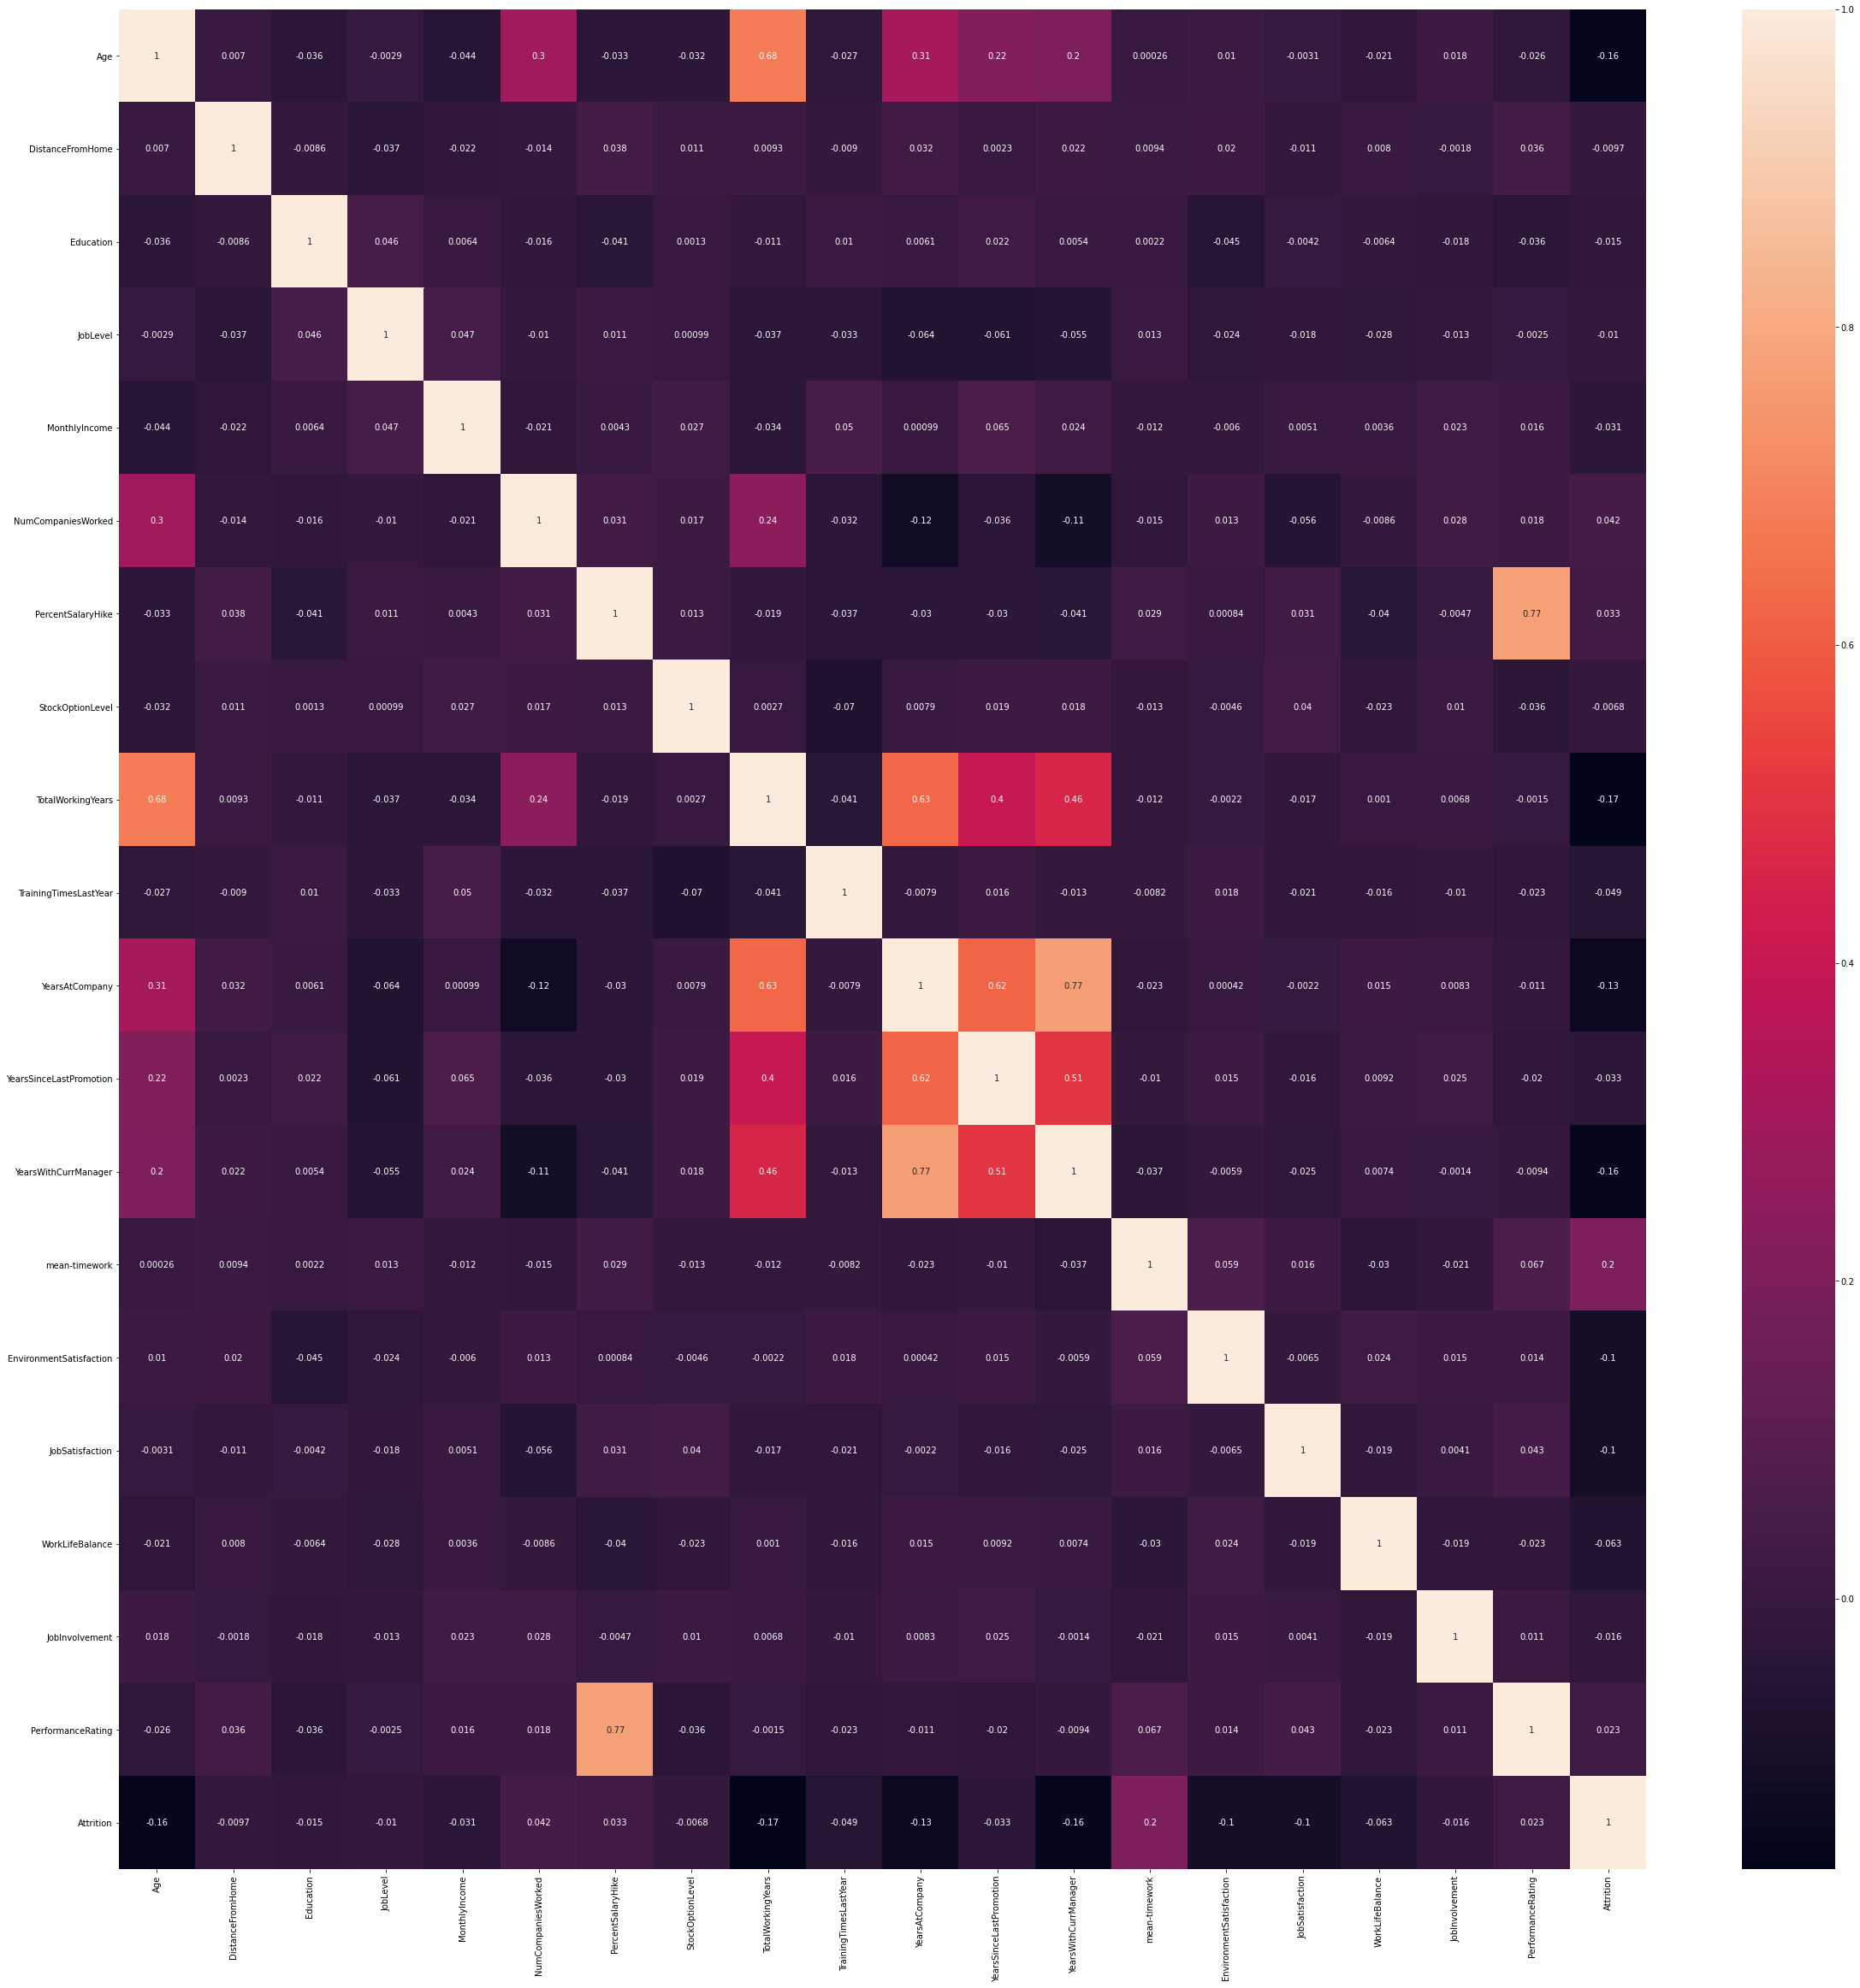

In [60]:
import seaborn as sns
plt.figure(figsize = (40,40))   
sns.heatmap(X_corr.corr(method='pearson'), annot= True)
plt.show()

In [61]:
X_corr.columns

Index(['Age', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'mean-timework',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'JobInvolvement', 'PerformanceRating', 'Attrition'],
      dtype='object')

In [62]:
X_corr_2 = X_corr.loc[:, :]

X_corr_2 = X_corr_2.drop(columns=['Age', 'Education', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager'])
plt.figure(figsize=(50, 40))

correlation = X_corr_2.corr(method='spearman')
correlation.describe()
#sns.heatmap(correlation, annot=True, annot_kws={'size': 22})
#plt.show()

,DistanceFromHome,JobLevel,MonthlyIncome,StockOptionLevel,mean-timework,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Attrition
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,0.090998,0.081323,0.097389,0.091963,0.117152,0.089691,0.085033,0.080825,0.087909,0.107645,0.083562
std,0.302223,0.305573,0.300441,0.302039,0.299352,0.304160,0.306034,0.305786,0.302983,0.297597,0.313497
min,-0.028046,-0.030282,-0.025227,-0.030282,-0.027583,-0.095300,-0.101424,-0.049217,-0.027583,-0.029323,-0.101424
25%,-0.016271,-0.027193,-0.012697,-0.008132,-0.006580,-0.004654,-0.020732,-0.026570,-0.015760,0.007315,-0.036741
50%,0.001419,-0.018424,0.012993,-0.002921,0.014702,0.016503,-0.001654,-0.009200,0.007266,0.016539,-0.009519
75%,0.017884,0.002183,0.034989,0.025312,0.063417,0.022894,0.028827,0.016917,0.014809,0.043869,0.011000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Figure size 3600x2880 with 0 Axes>